In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.master("local[*]").appName('BTCK').getOrCreate()

In [3]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [4]:
from pyspark.sql.types import *
trainschema = StructType([
    StructField("id",IntegerType(), True),
    StructField('Gender',StringType(),True),
    StructField('Age',DoubleType(),True),
    StructField('Driving_License', IntegerType(), True),
    StructField('Region_Code',DoubleType(), True),
    StructField('Previously_Insured',IntegerType(),True),
    StructField('Vehicle_Age', StringType(),True),
    StructField('Vehicle_Damage', StringType(), True),
    StructField('Annual_Premium', DoubleType(), True),
    StructField('Policy_Sales_Channel', DoubleType(), True),
    StructField('Vintage', DoubleType(), True),
    StructField('Response', IntegerType(), True)
])
testschema = StructType([
    StructField("id",IntegerType(), True),
    StructField('Gender',StringType(),True),
    StructField('Age',DoubleType(),True),
    StructField('Driving_License', IntegerType(), True),
    StructField('Region_Code',DoubleType(), True),
    StructField('Previously_Insured',IntegerType(),True),
    StructField('Vehicle_Age', StringType(),True),
    StructField('Vehicle_Damage', StringType(), True),
    StructField('Annual_Premium', DoubleType(), True),
    StructField('Policy_Sales_Channel', DoubleType(), True),
    StructField('Vintage', DoubleType(), True),
])

In [5]:
# Read data from directory
train = spark.read.csv('train.csv',header=True,schema=trainschema)
test = spark.read.csv('test.csv',header=True,schema=testschema)

In [6]:
# Rename column
train = train.withColumnRenamed("Driving_License","Has_License")\
            .withColumnRenamed("Region_Code","Region")\
            .withColumnRenamed("Previously_Insured","Has_Insured")\
            .withColumnRenamed("Vehicle_Damage","Damaged")\
            .withColumnRenamed("Policy_Sales_Channel","Sale_Channel")
test = test.withColumnRenamed("Driving_License","Has_License")\
            .withColumnRenamed("Region_Code","Region")\
            .withColumnRenamed("Previously_Insured","Has_Insured")\
            .withColumnRenamed("Vehicle_Damage","Damaged")\
            .withColumnRenamed("Policy_Sales_Channel","Sale_Channel")

In [7]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Has_License: integer (nullable = true)
 |-- Region: double (nullable = true)
 |-- Has_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Damaged: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Sale_Channel: double (nullable = true)
 |-- Vintage: double (nullable = true)
 |-- Response: integer (nullable = true)



In [8]:
test.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Has_License: integer (nullable = true)
 |-- Region: double (nullable = true)
 |-- Has_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Damaged: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Sale_Channel: double (nullable = true)
 |-- Vintage: double (nullable = true)



In [9]:
# Show train data
train.show(5)
print("Number rows of train data: {}".format(train.count()))
# Show test data
test.show(5)
print("Number rows of test data: {}".format(test.count()))

+---+------+----+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
| id|Gender| Age|Has_License|Region|Has_Insured|Vehicle_Age|Damaged|Annual_Premium|Sale_Channel|Vintage|Response|
+---+------+----+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
|  1|  Male|44.0|          1|  28.0|          0|  > 2 Years|    Yes|       40454.0|        26.0|  217.0|       1|
|  2|  Male|76.0|          1|   3.0|          0|   1-2 Year|     No|       33536.0|        26.0|  183.0|       0|
|  3|  Male|47.0|          1|  28.0|          0|  > 2 Years|    Yes|       38294.0|        26.0|   27.0|       1|
|  4|  Male|21.0|          1|  11.0|          1|   < 1 Year|     No|       28619.0|       152.0|  203.0|       0|
|  5|Female|29.0|          1|  41.0|          1|   < 1 Year|     No|       27496.0|       152.0|   39.0|       0|
+---+------+----+-----------+------+-----------+-----------+-------+--------------+-----

In [10]:
# Check missing data
from pyspark.sql.functions import isnan, when, count, col
train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).show()
test.select([count(when(isnan(c), c)).alias(c) for c in test.columns]).show()

+---+------+---+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
| id|Gender|Age|Has_License|Region|Has_Insured|Vehicle_Age|Damaged|Annual_Premium|Sale_Channel|Vintage|Response|
+---+------+---+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
|  0|     0|  0|          0|     0|          0|          0|      0|             0|           0|      0|       0|
+---+------+---+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+

+---+------+---+-----------+------+-----------+-----------+-------+--------------+------------+-------+
| id|Gender|Age|Has_License|Region|Has_Insured|Vehicle_Age|Damaged|Annual_Premium|Sale_Channel|Vintage|
+---+------+---+-----------+------+-----------+-----------+-------+--------------+------------+-------+
|  0|     0|  0|          0|     0|          0|          0|      0|             0|           0|      0|
+---+------+---+--

In [11]:
# Describe data
numeric_data = [name for name, type in train.dtypes if type == 'double']
train.select(numeric_data).describe().show()
test.select(numeric_data).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|               Age|            Region|    Annual_Premium|      Sale_Channel|           Vintage|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|            381109|            381109|            381109|            381109|            381109|
|   mean|38.822583565331705|26.388807401557035|30564.389581458323|112.03429465061177|154.34739667654136|
| stddev| 15.51161101809537|  13.2298880257885|17213.155056980144| 54.20399477485625| 83.67130362658722|
|    min|              20.0|               0.0|            2630.0|               1.0|              10.0|
|    max|              85.0|              52.0|          540165.0|             163.0|             299.0|
+-------+------------------+------------------+------------------+------------------+------------------+

+-------+------------------+------------------+-------

In [7]:
# Drop duplicates
train = train.drop_duplicates()
print("Number row of train data: {}".format(train.count()))
test = test.drop_duplicates()
print("Number row of test data: {}".format(test.count()))

Number row of train data: 381109
Number row of test data: 127037


# EXPLORATORY DATA ANALYSIS

In [13]:
# !pip install seaborn

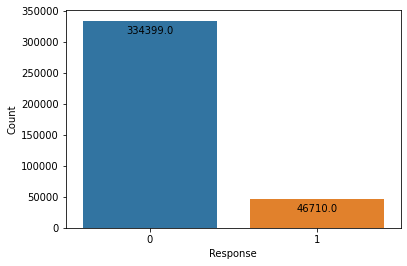

In [13]:
# response = pd.DataFrame(train.select('Response').groupBy('Response').count().collect(),columns=['response','count'])
response = train.select('Response').rdd.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y).collect()
response = pd.DataFrame(response, columns=['response', 'count'])
ax = sns.barplot(x=response['response'],y=response['count'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".1f"), 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha = "center", va ="center", xytext = (0,-10),
               textcoords = "offset points")
ax.set(xlabel='Response',ylabel='Count')
plt.show()

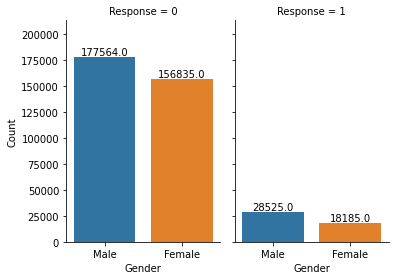

In [14]:
# df = pd.DataFrame(train.select('Gender','Response').groupBy('Gender','Response').count().collect()
#                 ,columns=['Gender','Response','Count'])
a = train.select('Gender','Response')\
        .rdd.map(lambda x: ((x[0], x[1]), 1))\
        .reduceByKey(lambda x, y: x + y)\
        .map(lambda x: (x[0][0], x[0][1], x[1])).collect()
df = pd.DataFrame(a,columns=['Gender','Response','Count'])
g = sns.catplot(x="Gender", y="Count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);
ax = g.facet_axis(0,0)

for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)
plt.savefig('Response_Gender.png')
plt.show()

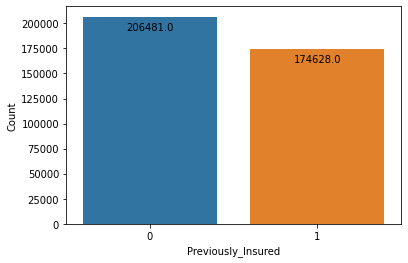

In [15]:
# previously_insured = pd.DataFrame(train.select('Has_Insured').groupBy('Has_Insured').count().collect()
#                                   ,columns=['Previously_Insured','Count'])
previously_insured = train.select('Has_Insured')\
                            .rdd.map(lambda x: (x[0], 1))\
                            .reduceByKey(lambda x, y: x + y).collect()
previously_insured = pd.DataFrame(previously_insured, columns=['Previously_Insured','Count'])
ax = sns.barplot(x=previously_insured['Previously_Insured'], y = previously_insured ['Count'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".1f"), 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha = "center", va ="center", xytext = (0,-10),
               textcoords = "offset points")
plt.show()

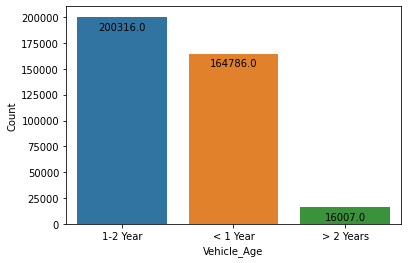

In [16]:
# vehicle_age = pd.DataFrame(train.select('Vehicle_Age').groupBy('Vehicle_Age').count().collect()
#                                   ,columns=['Vehicle_Age','Count'])
vehicle_age = train.select("Vehicle_Age")\
                    .rdd.map(lambda x: (x[0], 1))\
                    .reduceByKey(lambda x, y: x + y).collect()
vehicle_age = pd.DataFrame(vehicle_age, columns=["Vehicle_Age", "Count"])
ax = sns.barplot(x=vehicle_age['Vehicle_Age'], y=vehicle_age['Count'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".1f"), 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha = "center", va ="center", xytext = (0,-10),
               textcoords = "offset points")
plt.show()


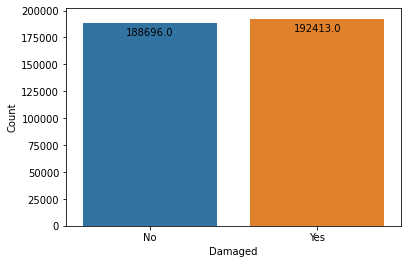

In [17]:
# damaged = pd.DataFrame(train.select('Damaged').groupBy('Damaged').count().collect()
#                                   ,columns=['Damaged','Count'])
damaged = train.select("Damaged")\
                .rdd.map(lambda x: (x[0], 1))\
                .reduceByKey(lambda x, y: x + y).collect()
damaged = pd.DataFrame(damaged, columns=['Damaged','Count'])
ax = sns.barplot(x=damaged['Damaged'], y=damaged['Count'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), ".1f"), 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha = "center", va ="center", xytext = (0,-10),
               textcoords = "offset points")
plt.show()

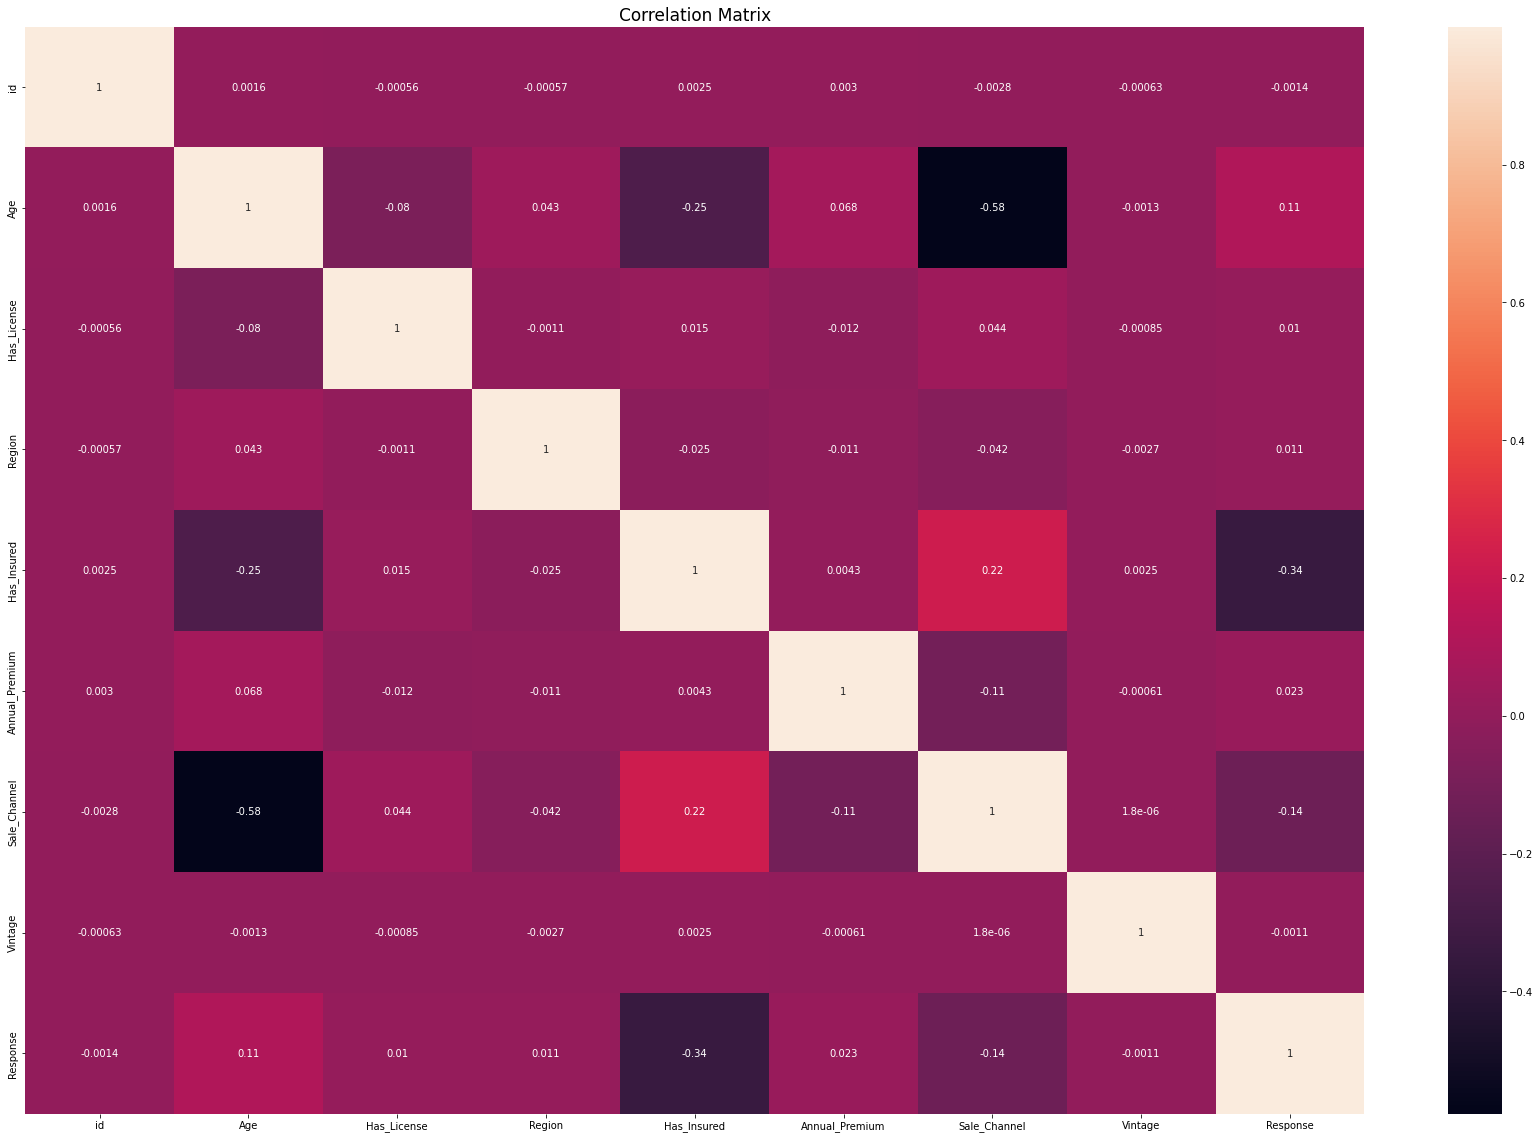

In [18]:
plt.figure(figsize=(30, 20))
# calculates the covariance between x and y
numeric_data = [train.columns.index(name) for name, type in train.dtypes if type == 'double' or type == 'int']
def calcCov(x, y):
    mean_x = train.agg({x: "mean"}).collect()[0][0]
    mean_y = train.agg({y: "mean"}).collect()[0][0]
    n = train.rdd.count()
    cov = train.select(x,y).rdd.map(lambda x: (x[0] - mean_x) * (x[1] - mean_y)).reduce(lambda x, y: x + y)
    return cov / n

# calculates the Covariance matrix
def corrMat(data):
    # get number of cols
    cols = len(numeric_data)
 
    # the covariance matrix has a shape of n_features x n_features
    cov_mat = np.zeros((cols, cols))
    # caculate std of columns
    stddev_array = [train.agg({train.columns[i]: "stddev"}).collect()[0][0] for i in numeric_data]
    for i in range(cols):
        for j in range(cols):
            x = train.columns[numeric_data[i]]
            y = train.columns[numeric_data[j]]
            # store the value in the matrix
            cov_mat[i][j] = calcCov(x, y) / (stddev_array[i] * stddev_array[j])
    return cov_mat
cov_mat = pd.DataFrame(corrMat(train),columns=[train.columns[i] for i in numeric_data], index=[train.columns[i] for i in numeric_data])
sns.heatmap(cov_mat, annot=True)
plt.title('Correlation Matrix', size = 17)
plt.savefig("corr.png")

# PREPROCESSING DATA


In [8]:
# Find string column
string_data = [name for name, type in train.dtypes if type == 'string']

In [9]:
from pyspark.sql.functions import col, expr, when
# Convert train data (string --> int)
train = train.withColumn('Gender',when(col('Gender') == 'Male', 1).otherwise(0))
train = train.withColumn('Vehicle_Age',\
                         when(col('Vehicle_Age') == '> 2 Years', 2)\
                        .when(col('Vehicle_Age') == '1-2 Year', 1)\
                                    .otherwise(0)
                        )
train = train.withColumn('Damaged', when(col('Damaged') == 'Yes',1).otherwise(0))
# Convert test data (string --> int)
test = test.withColumn('Gender',when(col('Gender') == 'Male', 1).otherwise(0))
test = test.withColumn('Vehicle_Age',\
                         when(col('Vehicle_Age') == '> 2 Years', 2)\
                        .when(col('Vehicle_Age') == '1-2 Year', 1)\
                                    .otherwise(0)
                        )
test = test.withColumn('Damaged', when(col('Damaged') == 'Yes',1).otherwise(0))

In [10]:
train.show(5)
test.show(5)

+----+------+----+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
|  id|Gender| Age|Has_License|Region|Has_Insured|Vehicle_Age|Damaged|Annual_Premium|Sale_Channel|Vintage|Response|
+----+------+----+-----------+------+-----------+-----------+-------+--------------+------------+-------+--------+
| 427|     1|22.0|          1|  46.0|          1|          0|      0|       23810.0|       152.0|  220.0|       0|
| 817|     0|36.0|          1|  28.0|          1|          1|      0|        2630.0|       125.0|  232.0|       0|
|1164|     1|28.0|          1|  27.0|          1|          0|      0|       25757.0|       152.0|  129.0|       0|
|1165|     1|40.0|          1|  28.0|          1|          1|      0|       58145.0|       124.0|  172.0|       0|
|1185|     0|24.0|          1|  15.0|          0|          0|      1|       47809.0|       152.0|   24.0|       0|
+----+------+----+-----------+------+-----------+-----------+-------+-----------

In [11]:
# Standardlize data
for column in train.columns[1:-1]:
    mean_val = train.agg({column: "mean"}).collect()[0][0]
    stddev_val = train.agg({column: "stddev"}).collect()[0][0]
    train = train.withColumn(column,(train[column] - mean_val)/ stddev_val)
# Rescale test dataset
for column in test.columns[1:]:
    mean_val = test.agg({column: "mean"}).collect()[0][0]
    stddev_val = test.agg({column: "stddev"}).collect()[0][0]
    test = test.withColumn(column,(test[column] - mean_val)/stddev_val)

In [12]:
train.show(5)
test.show(5)

+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------+
|  id|             Gender|                Age|        Has_License|             Region|        Has_Insured|        Vehicle_Age|            Damaged|      Annual_Premium|       Sale_Channel|            Vintage|Response|
+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------+
| 427| 0.9215435504762786|-1.0845155635805366|0.04620787482926694| 1.4823400288963673| 1.0873829964582606|-1.0743272667499517|-1.0097998193594062| -0.3923969521624305| 0.7373202937420228| 0.7846489833175837|       0|
| 817|-1.0851330635019185|-0.1819658552576502|0.04620787482926694|0.12178429592921243| 1.0873829964582606| 0.6879754505220637|-1.009

# LOGISTIC REGRESSION

In [13]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

In [14]:
def weights_gradient(rdd_row, w, b):
    x = rdd_row[1:-1]
    y = rdd_row[-1]
    residual = sigmoid(sum([x_j*w_j for x_j, w_j in zip(x, w)])) - y # dot product
    weights_gradient = [x_j * residual for x_j in x]
    return weights_gradient,residual

In [15]:
def cum_sum_gradients(row, next_row):
    return [gradient+next_gradient for gradient, next_gradient in zip(row, next_row)]

In [16]:
def distributed_gradient_descent(df, learning_rate=0.01, n_iters=100):
    w = np.zeros(len(df.rdd.first())-2).tolist() # -2 because the first, last value is id, y
    m = df.rdd.count()
    b = 0
    for i in range(n_iters):
        rdd_gradient = df.rdd.map(lambda row: weights_gradient(row, w, b))\
                            .map(lambda row: row[0])\
                            .reduce(lambda x, y: cum_sum_gradients(x, y))
        b_gradient = df.rdd.map(lambda row: weights_gradient(row, w, b))\
                            .map(lambda row: row[1])\
                            .reduce(lambda x, y: x + y)
        # scaling with m and learning rate
        w_gradient = [learning_rate*(w/m) for w in rdd_gradient]
        b_gradient = b_gradient * learning_rate / m
        # updating weights
        w = [w_j - w_grad_j for w_j, w_grad_j in zip(w, w_gradient)]
        b = b - b_gradient
    return w, b

In [17]:
def predict(X, coef, b):
    # Calculating presictions/y_hat.
    pred_class = X.rdd.map(lambda x: (x[0],sigmoid(sum([coef[i] * x[i + 1] for i in range(0, len(coef))]) + b)))\
                    .map(lambda x: (x[0],1 if x[1] >= 0.5 else 0)).collect()
    return pred_class

In [18]:
def accuracy(y, y_hat):
    y_hat_rdd = sc.parallelize(y_hat)
    accuracy = y.rdd.map(lambda x: (x[0], x[-1])).join(y_hat_rdd)\
                    .map(lambda x: 1 if x[1][0] == x[1][1] else 0)\
                    .reduce(lambda x, y: x + y)
    return accuracy / len(y_hat) * 100

In [19]:
# Define score
def score(y, y_hat):
    y_hat_rdd = sc.parallelize(y_hat)
    rdd_kq = y.rdd.map(lambda x: (x[0], x[-1])).join(y_hat_rdd)
    tp = rdd_kq.map(lambda x: 1 if (x[1][0] == 0 and x[1][1] == 0) else 0).reduce(lambda x, y: x + y)
    fp = rdd_kq.map(lambda x: 1 if (x[1][0] == 1 and x[1][1] == 0) else 0).reduce(lambda x, y: x + y)
    fn = rdd_kq.map(lambda x: 1 if (x[1][0] == 0 and x[1][1] == 1) else 0).reduce(lambda x, y: x + y)
    tn = rdd_kq.map(lambda x: 1 if (x[1][0] == 1 and x[1][1] == 1) else 0).reduce(lambda x, y: x + y)
    score_array = np.array([[tp,fn],[fp,tn]])
    print(score_array)
    precision = tp/(tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    return score_array, precision, recall, f1_score

In [20]:
# Create sample submission schema
sample_submission_schema = StructType([
    StructField("id",IntegerType(), True),
    StructField('Response', IntegerType(), True)
])
# Read sample_submission.csv
sample_submission = spark.read.csv('sample_submission.csv', header = True, schema = sample_submission_schema)

In [21]:
# Train model 
import time
start = time.time()
coef, b = distributed_gradient_descent(train,0.01,100)
end = time.time()
print(coef)
print(b)
print("Total runtime: {} (s)".format(end - start))

[0.011472216697762752, 0.019090325531882297, 0.003966181723402482, 0.0019332341768192997, -0.085799438695305, 0.05150147079188825, 0.08984663028622913, 0.005605904409461745, -0.0301607528462803, -0.00023424520615248376]
-0.3774392233142085
Total runtime: 1389.014487028122 (s)


In [22]:
# Predict and calculate accuracy of agorithm
y_hat = predict(test, coef, b)
acc = accuracy(sample_submission, y_hat)
print("Accuracy of Logistic Regression: {}".format(acc))

Accuracy of Logistic Regression: 99.25454788762329


In [23]:
# Split train dataset --> 0.8 train and 0.2 test
train, test = train.randomSplit([0.8, 0.2],24)
test_target = test.select(["id","Response"])
test = test.drop("Response")
# Train model
start = time.time()
coef, b = distributed_gradient_descent(train,0.01,100)
end = time.time()
print(coef)
print(b)
print("Total runtime: {} (s)".format(end - start))
# Predict and calculate accuracy of agorithm
y_hat = predict(test, coef, b)
acc = accuracy(test_target, y_hat)
print("Accuracy of Logistic Regression: {}".format(acc))

[0.011559597525653104, 0.018836768172042252, 0.004239608179705358, 0.0023359334336068146, -0.08570032266432084, 0.05107674647727979, 0.08964693807703972, 0.005030463664491176, -0.029559849094360165, 0.0001988767124784203]
-0.3779344456176217
Total runtime: 1260.7431297302246 (s)
Accuracy of Logistic Regression: 87.3197218095526


In [24]:
score_array, precision, recall, f1_score = score(test_target,y_hat)

[[66288   302]
 [ 9343   130]]


In [25]:
print(precision, recall, f1_score)

0.8764659993917838 0.9954647845021775 0.9321830109477504


Precision = 0.8764659993917838, recall = 0.9954647845021775, f1_score = 0.9321830109477504


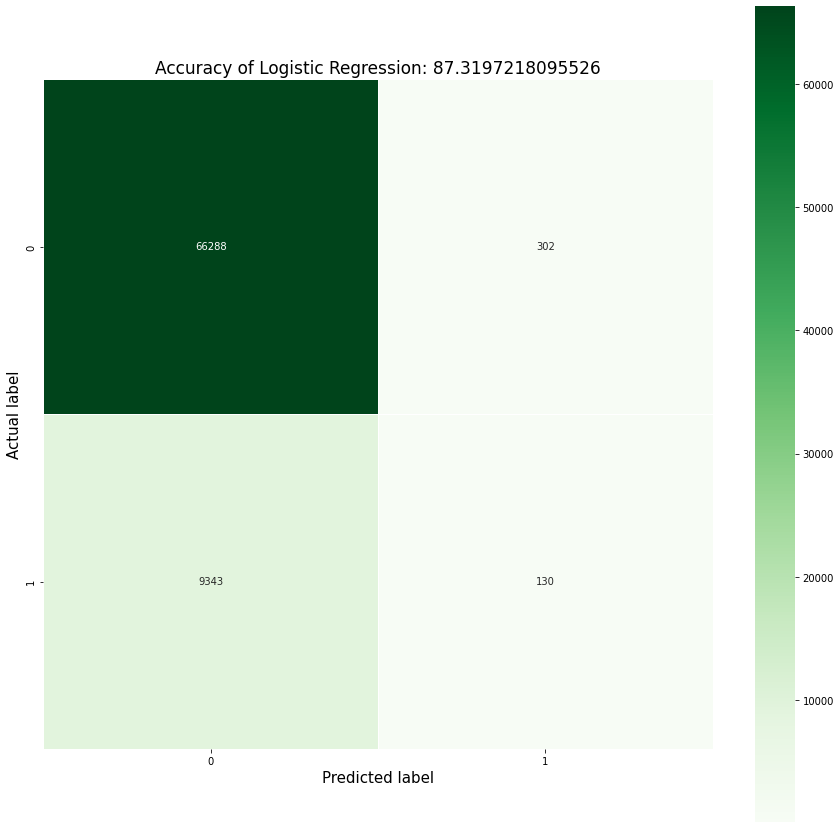

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
print("Precision = {}, recall = {}, f1_score = {}".format(precision, recall, f1_score))
plt.figure(figsize=(15,15))
sns.heatmap(score_array, annot=True, fmt='.0f', linewidths=.5, square=True, cmap='Greens')
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
plt.title('Accuracy of Logistic Regression: {}'.format(acc), size = 17)
plt.savefig("acc.png")
plt.show()
